In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [9]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset(
    data_root='../data/BIOQIC', data_name='fem_box', frequency=80, xyz_slice='2D'
)
data

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Single frequency 2D
<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
    spatial_region  (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    a               (frequency, x, y, component) float64 -0.0 0.0 ... 0.0 -0.0
    u               (frequency, x, 

<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
    spatial_region  (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    a               (frequency, x, y, component) float64 -0.0 0.0 ... 0.0 -0.0
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    Ku              (frequency, x, y, component) complex128 (1.46219383298261...
    Lu              (frequency, x, y, component) complex128 (0.11374981040774...
    Mu              (frequency, x, y) complex128 (-249.98008993038866+1775.90...

<IPython.core.display.Javascript object>


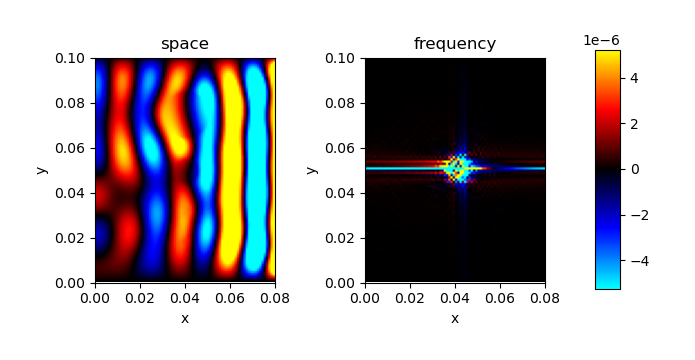

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


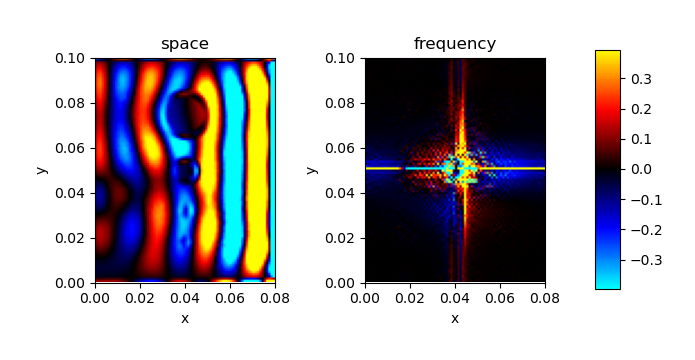

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


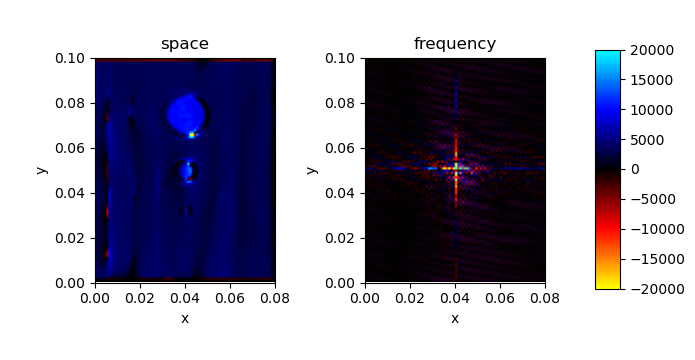

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


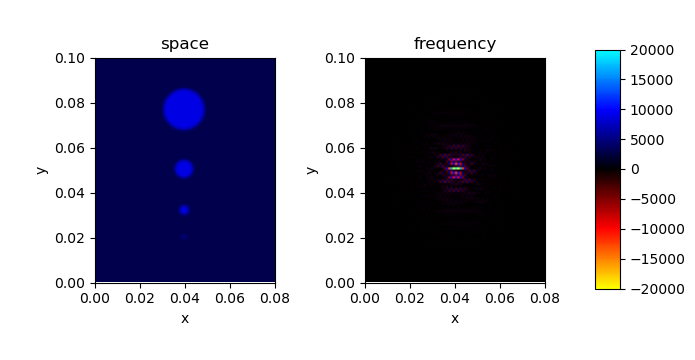

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

In [10]:
%autoreload

# configure color maps
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
elast_kws = mre_pinn.visual.get_color_kws(data.mu)

# display true wave field and elastogram
y = 'y' if 'y' in data.field.spatial_dims else None
hue = None if 'y' in data.field.spatial_dims else 'part'
mre_pinn.visual.XArrayViewer(data.u,  col='domain', y=y, hue=None, ax_width=2, **wave_kws)
mre_pinn.visual.XArrayViewer(data.Lu, col='domain', y=y, hue=None, ax_width=2, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu.mean('frequency'), col='domain', y=y, hue=None, ax_width=2, **elast_kws)
mre_pinn.visual.XArrayViewer(data.mu.mean('frequency'), col='domain', y=y, hue=None, ax_width=2, **elast_kws)

In [11]:
%autoreload

net = mre_pinn.pinn.MultiPINN(
    n_input=data.field.n_spatial_dims + 1,
    n_outputs=[data.field.n_spatial_dims, 1],
    omega0=16,
    n_layers=5,
    n_hidden=128,
    activ_fn='t',
    parallel=True,
    dense=True,
    dtype=torch.float32
)
net

MultiPINN(
  (input_scaler): InputScaler()
  (net): Parallel(
    (0): PINN(
      (linear0): Linear(in_features=3, out_features=128, bias=True)
      (linear1): Linear(in_features=131, out_features=128, bias=True)
      (linear2): Linear(in_features=259, out_features=128, bias=True)
      (linear3): Linear(in_features=387, out_features=128, bias=True)
      (linear4): Linear(in_features=515, out_features=4, bias=True)
    )
    (1): PINN(
      (linear0): Linear(in_features=3, out_features=128, bias=True)
      (linear1): Linear(in_features=131, out_features=128, bias=True)
      (linear2): Linear(in_features=259, out_features=128, bias=True)
      (linear3): Linear(in_features=387, out_features=128, bias=True)
      (linear4): Linear(in_features=515, out_features=2, bias=True)
    )
  )
  (output_scaler): OutputScaler()
)

Compiling model...
'compile' took 0.000205 s

Training model...



<IPython.core.display.Javascript object>


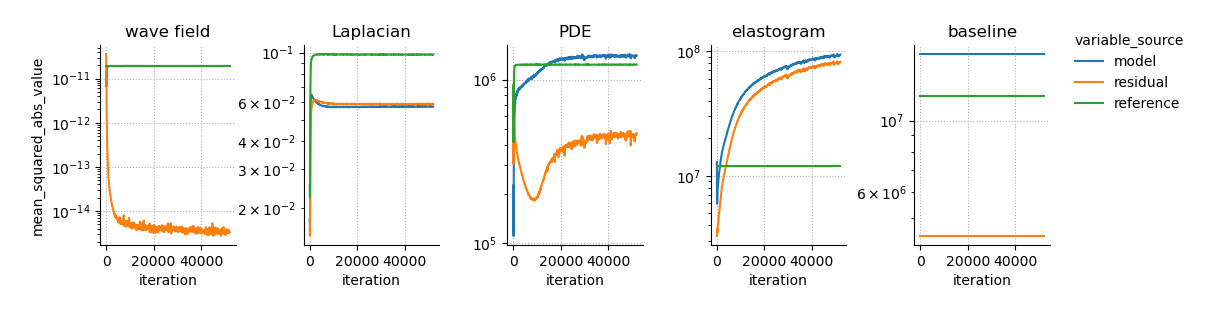

<IPython.core.display.Javascript object>


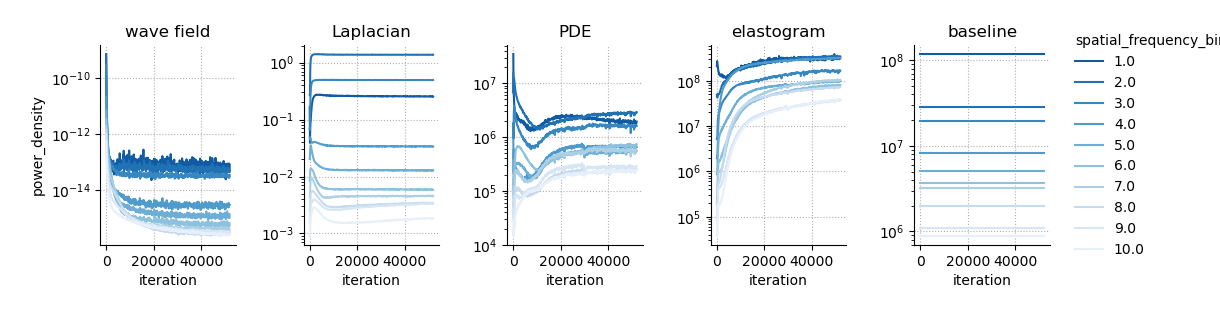

<IPython.core.display.Javascript object>


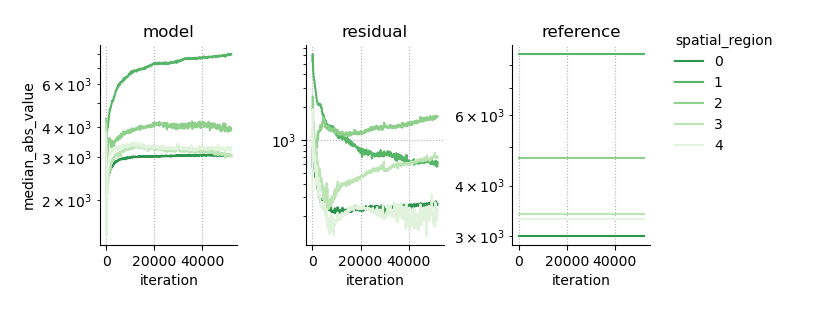

<IPython.core.display.Javascript object>


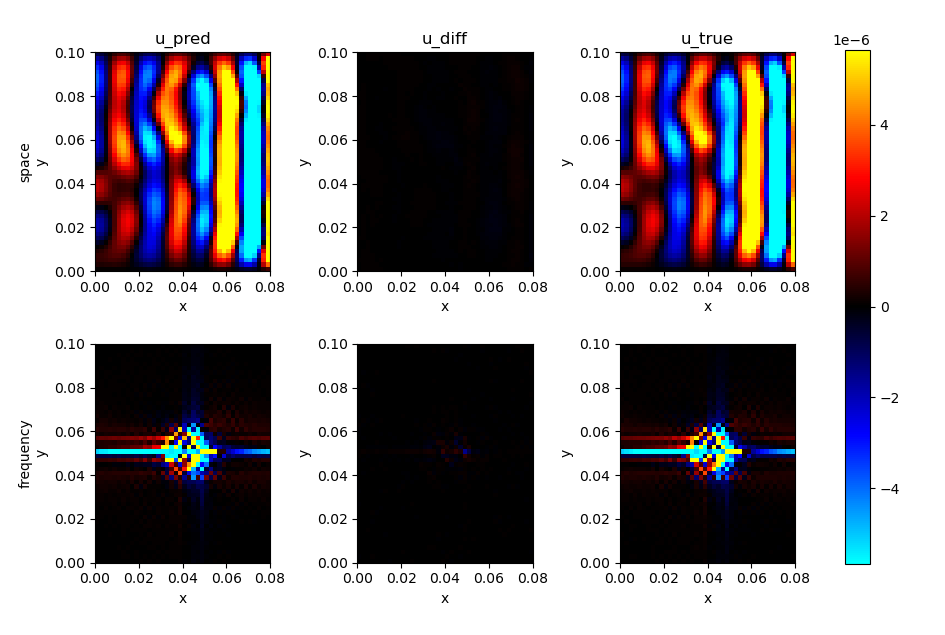

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


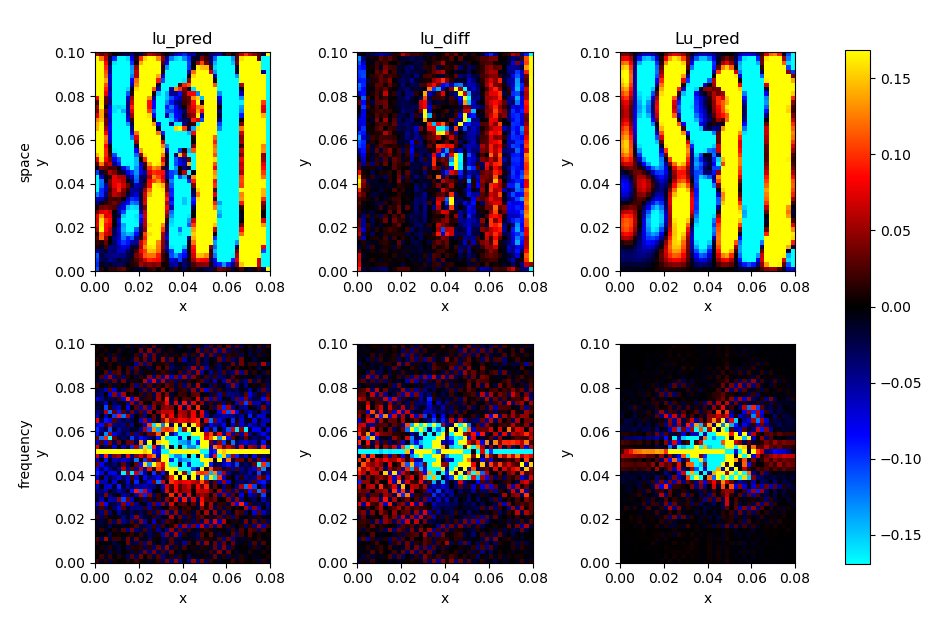

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


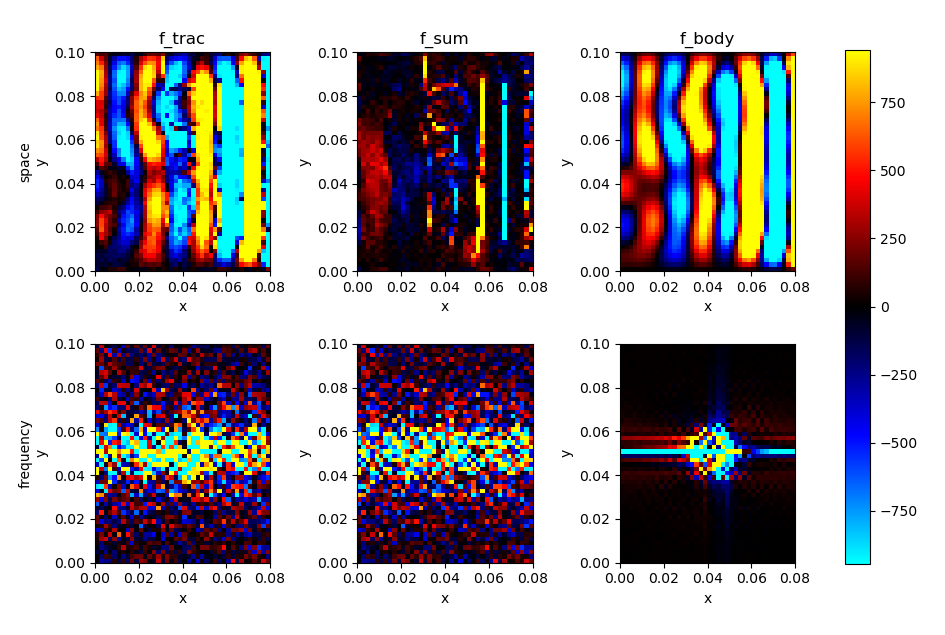

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


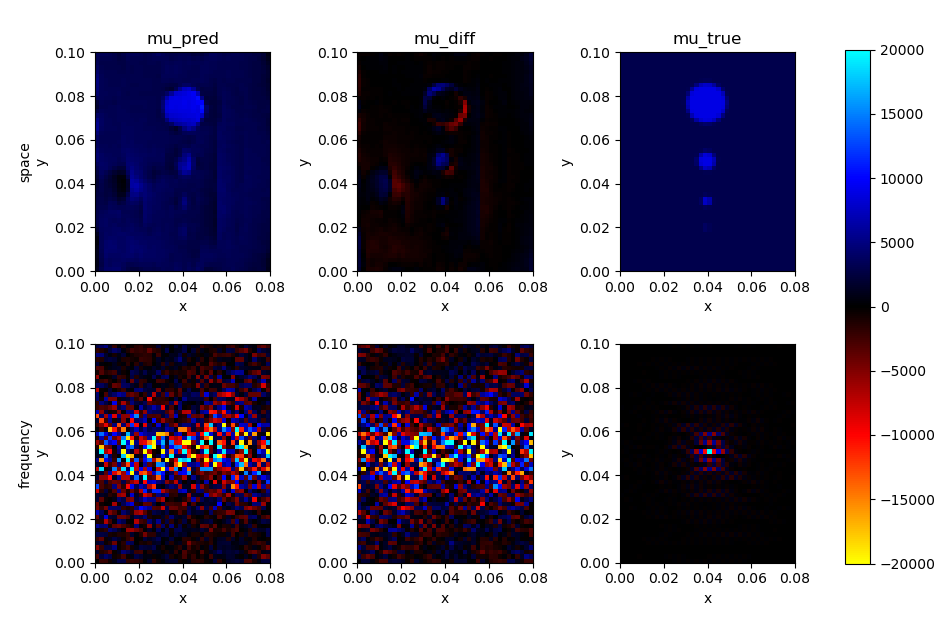

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


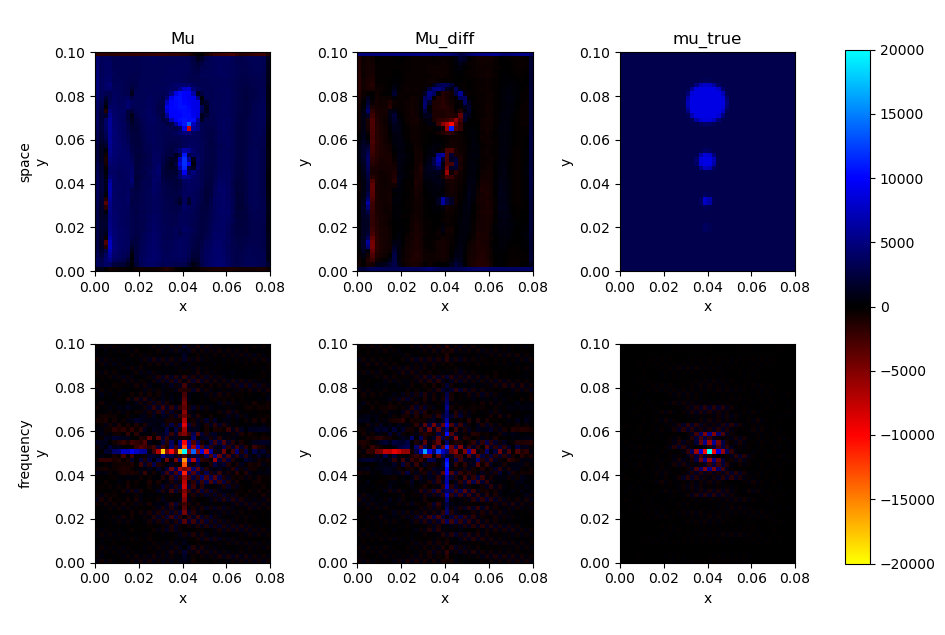

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

Time spent testing: 55.82%
Time spent testing: 49.44%
Time spent testing: 47.66%
Time spent testing: 46.12%
Time spent testing: 45.11%
Time spent testing: 44.44%
Time spent testing: 43.97%
Time spent testing: 43.62%
Time spent testing: 43.33%
Time spent testing: 43.09%
Time spent testing: 42.92%
Time spent testing: 42.79%
Time spent testing: 42.69%
Time spent testing: 42.79%
Time spent testing: 42.70%
Time spent testing: 42.62%
Time spent testing: 42.55%
Time spent testing: 42.49%
Time spent testing: 42.45%
Time spent testing: 42.40%
Time spent testing: 42.38%
Time spent testing: 42.35%
Time spent testing: 42.33%
Time spent testing: 42.42%
Time spent testing: 42.40%
Time spent testing: 42.38%
Time spent testing: 42.36%
Time spent testing: 42.35%
Time spent testing: 42.34%
Time spent testing: 42.31%
Time spent testing: 42.30%
Time spent testing: 42.29%
Time spent testing: 42.28%
Time spent testing: 42.27%
Time spent testing: 42.34%
Time spent testing: 42.33%
Time spent testing: 42.32%
T

Time spent testing: 46.75%
Time spent testing: 46.77%
Time spent testing: 46.79%
Time spent testing: 46.81%
Time spent testing: 46.84%
Time spent testing: 46.87%
Time spent testing: 46.89%
Time spent testing: 46.92%
Time spent testing: 46.94%
Time spent testing: 46.97%
Time spent testing: 47.00%
Time spent testing: 47.02%
Time spent testing: 47.05%
Time spent testing: 47.08%
Time spent testing: 47.10%
Time spent testing: 47.13%
Time spent testing: 47.16%
Time spent testing: 47.18%
Time spent testing: 47.21%
Time spent testing: 47.23%
Time spent testing: 47.26%
Time spent testing: 47.28%
Time spent testing: 47.31%
Time spent testing: 47.33%
Time spent testing: 47.36%
Time spent testing: 47.38%
Time spent testing: 47.40%
Time spent testing: 47.43%
Time spent testing: 47.45%
Time spent testing: 47.48%
Time spent testing: 47.50%
Time spent testing: 47.53%
Time spent testing: 47.55%
Time spent testing: 47.58%
Time spent testing: 47.60%
Time spent testing: 47.63%
Time spent testing: 47.65%
T

Interrupt


In [13]:
%autoreload

pde = mre_pinn.pde.WaveEquation.from_name('hetero', detach=True)
model = mre_pinn.training.PINNModel(data, net, pde, batch_size=128)
model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1e0, 1e-8],
    loss=mre_pinn.training.standardized_msae_loss_fn(data.u.values)
)
deepxde.display.training_display = mre_pinn.training.SummaryDisplay()

test_eval = mre_pinn.testing.TestEvaluator(
    test_data, model, batch_size=128, test_every=100, save_every=1000, interact=True
)
try:
    model.train(100000, display_every=10, callbacks=[test_eval])
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)